In [32]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [33]:
path = 'C:/Users/Chloé/Desktop/csulb/lfw'

In [34]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [35]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


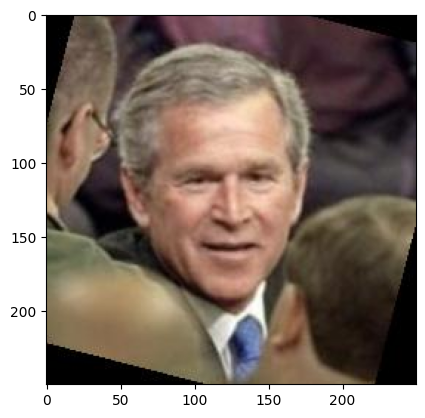

In [36]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [37]:
for x,y in dataloader:
    sample_image= x[0]
    break
    
print("Sample Image Shape:", sample_image.shape)


Sample Image Shape: torch.Size([3, 250, 250])


The first 250 might be related to height, second 250 related to width and the last element, 3, to the number of channels in each image (if 3 here, we can suppose it's RGB)

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [38]:
import torch.nn as nn

class AE(nn.Module):
    
    def __init__(self):
        super(AE, self).__init__()

        #Encode Layers
        self.encoder_layers = nn.Sequential(
            nn.Conv2d(3,64,3,stride = 2,padding = 1),
            nn.ReLU(True),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(64,128,3,stride=2)
        )

        self.decoder_layers = nn.Sequential(
            nn.ConvTranspose2d(128,64,3,stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,3,4,stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(3,3,4,stride=2),
            nn.Sigmoid()
        )
    def encoder(self, x):
        return self.encoder_layers(x)

    def decoder(self, x):
        return self.decoder_layers(x)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [39]:
model = AE()

output_image = model(sample_image)

In [40]:
encoder_output = model.encoder(output_image)
decoder_output = model.decoder(encoder_output)

print("Encoder Output Shape:", encoder_output.shape)
print("Decoder Output Shape:", decoder_output.shape)

Encoder Output Shape: torch.Size([128, 30, 30])
Decoder Output Shape: torch.Size([3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [41]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params}")


Total Parameters: 152662


In [42]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [43]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [44]:
num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0.0
    for batch in dataloader:
        images, _ = batch

        outputs = model(images)
        loss = loss_function(outputs, images)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss}")

print("Training finished.")


Epoch [1/5], Loss: 0.05664950787373211
Epoch [2/5], Loss: 0.05887812629773997
Epoch [3/5], Loss: 0.05067640658162066
Epoch [4/5], Loss: 0.057228239019207906
Epoch [5/5], Loss: 0.054009979707751295
Training finished.


In order to troubleshoot the loss  not decreasing, we can try different optimizer, different models, or even check input data.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

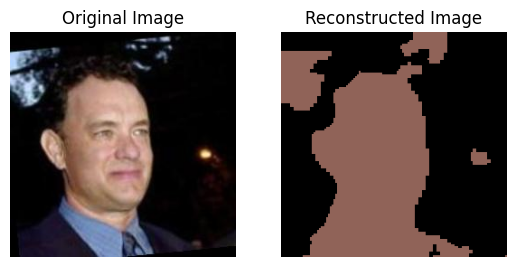

In [68]:
model.eval()

random_index = random.randint(0, len(dataloader.dataset) - 1)
sample_image, _ = dataloader.dataset[random_index]

sample_image = sample_image.unsqueeze(0)

reconstructed_image = model(sample_image)

sample_image_np = sample_image.squeeze().permute(1, 2, 0).numpy()
reconstructed_image_np = reconstructed_image.squeeze().permute(1, 2, 0).detach().numpy()

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(sample_image_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_np)
plt.axis('off')

plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

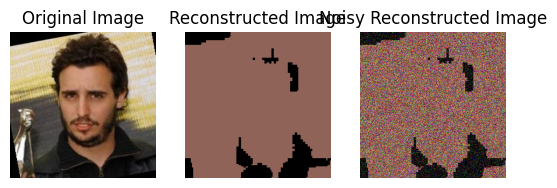

In [91]:
model.eval()

random_index = random.randint(0, len(dataloader.dataset) - 1)
sample_image, _ = dataloader.dataset[random_index]

sample_image = sample_image.unsqueeze(0)

reconstructed_image = model(sample_image)

sample_image_np = sample_image.squeeze().permute(1, 2, 0).numpy()
reconstructed_image_np = reconstructed_image.squeeze().permute(1, 2, 0).detach().numpy()

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(sample_image_np)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_np)
plt.axis('off')

#Adding noise
with torch.no_grad():
    noisy_reconstructed_image = reconstructed_image.clone()
    noisy_reconstructed_image_np = noisy_reconstructed_image.squeeze().permute(1, 2, 0).numpy()
    noise = np.random.normal(0, 0.2, noisy_reconstructed_image_np.shape)
    noisy_reconstructed_image_np = noisy_reconstructed_image_np + noise
    noisy_reconstructed_image_np = np.clip(noisy_reconstructed_image_np, 0, 1)
    noisy_reconstructed_image = torch.tensor(noisy_reconstructed_image_np).permute(2, 0, 1).unsqueeze(0).float()


noisy_reconstructed_image_np = noisy_reconstructed_image.squeeze().permute(1, 2, 0).numpy()

plt.subplot(1, 3, 3)
plt.title("Noisy Reconstructed Image")
plt.imshow(noisy_reconstructed_image_np)
plt.axis('off')

plt.show()


It gives the impression to "blur" the image as it adds pixels of several different colors.